# **Setup Enviroment**

In [ ]:
from sklearn.model_selection import LeaveOneOut,KFold, StratifiedKFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
#from google.colab import drive
from keras import backend as K
from random import shuffle
import itertools as tools
import tensorflow as tf
import pickle as pkl
from os import walk
import pandas as pd
import numpy as np
import ast
import gc
import os as os

%matplotlib inline
#drive.mount('/content/gdrive', force_remount=True)

In [ ]:
dataset_path = './data'

os.makedirs('./' + 'data', exist_ok=True) 

# **Data**

Using GCDC dataset. Enron datas are in jsonl format. We gona inport than to pandas dataframe.

(*) 3 different label - high, medium and low

Tranform json fila to csv:

In [ ]:
df = pd.read_json(dataset_path+'/Enron_train.jsonl', lines=True)

In [ ]:
df = df[['text','label']]

In [ ]:
# change 1 and 2 to 0 9 non coherence
df.loc[df['label'] <=2, 'label'] = 0

In [ ]:
# change 1 and 2 to 0 (non coherence)
df.loc[df['label'] >0, 'label'] = 1

In [ ]:
df.label.value_counts()

1    406
0    394
Name: label, dtype: int64

In [ ]:
# import sidetable
# df.stb.freq(['label'], value='label(Count)', style=True, cum_cols=False)

In [ ]:
# df.text = str.maketrans('', '', string.punctuation)
# df['text'] = df['text'].str.replace(r'[^\w\s]+', '')
df['text'] = df['text'].replace(r'\s+|\\n', ' ', regex=True) 

In [ ]:
df['text'][0]

'John - FYI. From what I vave seen thus far I think it will be difficult getting anything accurate or timely out of Evan Hughes\' group. This is the group that is responsible for billing and settlements - the weakest link in our reconciliation problems. Unlike ENA Power, Retail has Deal Capture and Risk Analysis under Sally Beck and the Settlements process under EES (Evan Hughes). All three of these functions need to work together and feed into Wade Stubblefield (Wes Colwell) in order to get an accurate and timely reconciliation. Dave has wanted to keep Billing and Settlements because of the "Customer Touch" they want to maintain. I think this approach is delaying our getting control of and resolving the issues that are keeping us from monthly reconciliations and cash to actual liquidations. I think EES needs to be given an ultimatum to 1) either provide us with a Settlements function that allows us to flash and reconcile or 2) get out of the way. We can provide them with the bill and 

Os textos mentem os pontos separados das sentenças. Isso nos permite separar as orações para analize pela CNN.

In [ ]:
from operator import index
df.to_csv(dataset_path + '/dataset.csv', header=True, index=False)

# **Word Enbeddings**

Downloading glove wordvectors:

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2022-11-20 14:11:57--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-11-20 14:11:57--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2022-11-20 14:14:36 (5.18 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!mv glove* ./data

# **Helper Funcions**

## **Processor**

In [ ]:
class Preprocessor:
    
    def __init__(self, embidding_dims= 100, max_sequence_length = 100, padding_type='post'):
        
        self.tokenizer = None
        self.embeddings_matrix = None
        self.embedding_dim = embidding_dims
        self.max_sequence_length = max_sequence_length
        self.padding_type = padding_type
        
    def __make_tokenizer(self, text, oov_token=''):
        '''
            make tokenizer from sentences
            
            -- inputs:
                sentences:text to fit tokenizer on
                oov_token: out of vocabulary token 
            -- returns:
                None
        '''
        self.tokenizer = Tokenizer(oov_token=oov_token)
        self.tokenizer.fit_on_texts(text)    
    
    def load_tokenizer(self, file_path):
        '''
            load tokenizer from pickle file
            
            -- inputs:
                file_path: path to the file of tokenizer 
            -- returns:
                None
        '''
        if  not (os.path.isfile(file_path)):
            # self.make_tokenizer(dataset_path, save_tokenizer=True, tokenizer_file_path='tokenizer.pkl')
            self.make_tokenizer(dataset_path, save_tokenizer=True, tokenizer_file_path=file_path)
            print('Criating tokenizer ...')

        try:
            self.tokenizer = pkl.load(open(file_path,'rb'))
            print(f'Tokenizer ready from {file_path}. word count len: {len(self.tokenizer.word_counts)}')
        except  Exception  as e :
            print(f'Could not load tokenizer from path: {file_path}\n{e}')
    
    
    def make_tokenizer(self, dataset_path, save_tokenizer=False, tokenizer_file_path=None):
        '''
            make a tokenizer from separate files
            
            -- inputs:
                file_path: path to the file of tokenizer 
            -- returns:
                None
        '''
        df = pd.read_csv(f'{dataset_path}/dataset.csv', sep=',')
        # self.tokenizer = 
        self.__make_tokenizer(np.array(df['text']))

        if save_tokenizer == True:
            try:
                pkl.dump(self.tokenizer, open(f'{tokenizer_file_path}', 'wb'))
            except Exception  as e :
                print(f'could not save tokenizer to path: {tokenizer_file_path}\n{e}')
    
    def make_embeddings(self, path_to_embeddings=dataset_path + '/glove.6B.100d.txt'):
        print(f'Making embedding from file: {path_to_embeddings}')
        if self.tokenizer == None:
            print('could not create embeddings matrix from empty tokenizer')
        
        else:  
            embeddings_index = {}
            vocab_size=len(self.tokenizer.word_index)

            with open(f'{path_to_embeddings}', encoding="utf8") as f:
                for line in f:
                    values = line.split()
                    word = values[0]
                    coefs = np.asarray(values[1:], dtype='float32')
                    embeddings_index[word] = coefs

            embedding_index = np.zeros((vocab_size+1, self.embedding_dim))
            for word, i in self.tokenizer.word_index.items():
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    embedding_index[i] = embedding_vector

            self.embeddings_matrix = embedding_index
        
    def tokenize_data(self, paragraphs):          
        sequence = self.tokenizer.texts_to_sequences(paragraphs)
        padded_sequence = pad_sequences(sequence, padding=self.padding_type,maxlen=self.max_sequence_length)
        return padded_sequence        
        

# **Data Transformer**

Data transformer: includes all functions that handle datsaet manipulations
**negrito**
- generate n-permutations of file
- clean up non-ascii characters from text line
- read file from directory
- generate paragraph-label pairs from data directory
- remove non-ascii characters from text line
- generate paragraphs of n-sentences from file
- generate paragraphs of n-sentences from file

In [ ]:
class DataTransformer:
    
    def __init__(self):
        pass
    
    def __permute_file(self, file_lines, size=10):
        '''
            returns all permutations of a file

            -- inputs:
                file_lines: list of file lines
                size: number of permutations to return, other than the original one
            -- returns:
                all permutations of the list element where the original ordering is the first element
        '''
        file_lines = np.array(file_lines)
        indeces = [i for i in range(file_lines.shape[0])]
        shuffled_set = set() 
        while len(shuffled_set) <size:
            shuffle(indeces)
            shuffled_set.add(tuple(indeces))

        permuted_lines = [file_lines]
        for idx in shuffled_set:
            permuted_lines.append(file_lines[list(idx)])

        return permuted_lines

    def __remove_non_ascii(self, text):
        return ''.join([i if ord(i) < 128 and i not in ['.', '\n', ','] else '' for i in text])

    def __read_file(self, file_path, skip_first_token=False):
        '''
            reads the lines from file

            -- inputs: 
                file_path: full path to the file to be permuted
                skip_first_token: boolean used to sanitize the inputs from the DUC dataset
            -- returns:
                list of the file lines
        '''
        #try:
        with open(file_path, 'r') as file:
            if skip_first_token == True:
                return [ self.__remove_non_ascii(line[line.find(' ') + 1:]) for line in file.readlines() ]
            return [ self.__remove_non_ascii(line) for line in file.readlines()]
        #except:
            '''file is either not found or path is wrong
            print(f"file {file_path} was not found!")
            return []'''

    def __get_file_labeled_permutations(self, file_path):
        '''
            generate all permutations of the file, label the original one as coherent, all other permutations are non-coherent

            -- inputs: 
                file_path: full path to the file to be permuted
            -- returns: 
                list of tuples of structure: (lines permutation, label: being 1 for coherent, 0 for non-coherent)
        '''
        file_lines = self.__read_file(file_path, skip_first_token=True)
        permuted_lines = self.__permute_file(file_lines, size=20)
        labels = [1] + [0 for i in range(len(permuted_lines)-1)]
        return zip(permuted_lines, labels)

    @staticmethod
    def generate_file_cliques(file_lines, size=3):

        '''
        divides the file into cliques of similar size

        -- inputs: 
            file_lines: list of file lines to be permuted
            size: size of cliques 
        -- returns:
            list of cliques generated
        '''
        cliques = []
        for idx in range(len(file_lines)-size):
            current_clique = []
            for increment in range(size):
                current_clique.append(file_lines[idx+increment])
            cliques.append(current_clique)

        return cliques
    
    def generate_separate_files_method(self, dataset_path, clique_size = 3):
        '''
            file structure is: n+1 lines where the first line is either 1 for coherent documents, 0 for non coherent
                followed by n-lines of the document.
        '''
        count = 0
        print(f'reading files from {dataset_path}')
        for (_, _, file_names) in walk(dataset_path):
            for file_name in file_names:
                for file_lines, label in self.__get_file_labeled_permutations(dataset_path+file_name):
                    for clique in DataTransformer.generate_file_cliques(file_lines, size=clique_size):
                        with open(f'./processed data/separate-files/{count}.txt','w') as file:
                            file.write(f'{label}. ')
                            for line in clique:
                                file.write(f'{line}. ')
                        count += 1
                        
    def generate_csv_dataset_from_separate_files (self, dataset_path, file_name):
        
        with open(f'{dataset_path}{file_name}', 'a') as csv_file:
            csv_file.write('data,label\n')

            for (_, _, file_names) in walk(dataset_path):
                for file_name in file_names:
                    file_lines = open(f'{dataset_path}{file_name}', 'r').readline().split('.')[:-1]
                    if len(file_lines) != 4:
                        print(file_name)
                    else:
                        for line in file_lines[1:]:
                            csv_file.write(f'{line}. ')
                        csv_file.write(f',{file_lines[0]}\n')

# **Model Definition**

## **Similarity Matrix**

**Model: includes all model related functionalities.**   


Similarity matrix: trainable matrix M that captures similarity between two sentences according to the equation:

similarity function

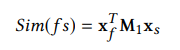


where:

- Xf: first sentence
- Xs: second sentence
- M: similarity matrix (trainable weights)

In [ ]:
class SimilarityMatrix(tf.keras.layers.Layer):

    def __init__(self,dims, **kwargs):
        self.dims_length, self.dims_width = dims
        super(SimilarityMatrix, self).__init__(**kwargs)

    def build(self, input_shape):
        
        # Create a trainable weight variable for this layer.
        self._m = self.add_weight(name='M', 
                                    shape=(self.dims_length,self.dims_width),
                                    initializer='uniform',
                                    trainable=True)
        super(SimilarityMatrix, self).build(input_shape)  # Be sure to call this at the end

    def call(self, y): 
        xf, xs = y
        sim1=tf.matmul(xf, self._m)
        transposed = tf.reshape(K.transpose(xs),(-1, 100, 1))
        sim2=tf.matmul(sim1, transposed)
        return sim2

    def compute_output_shape(self, input_shape):
        return (1)


    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'dims_length': self.dims_length, 
            'dims_width': self.dims_width
        })
        return config

## **Model Helper**

Model Helper: includes all training related functions

In [ ]:
class ModelHelper:
  
    @staticmethod
    def negative_log_likelihood(y_true, y_pred):
        
        '''
          Calculates negative log likelihood

          -- inputs: 
              y_true: ground truth  values
              y_predictions: non categorical predicted values
              y_pred: (optional) title for the plot
          -- returns:
              negative likelihood total loss 
        '''
        return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

    @staticmethod
    def plot_ROC(y_true, y_predictions, title=''):

        '''
          Plot ROC curve
          
          -- inputs: 
              y_true: ground truth  values
              y_predictions: non categorical predicted values
              title: (optional) title for the plot
          -- returns:
              None
        '''

        ## calculate the FPR, TPR, Thresholds and AUC value
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_true, y_predictions)
        auc_val = auc(false_pos_rate, true_pos_rate)

        ## plot ROC curve
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(false_pos_rate, true_pos_rate, label=f'{title}' +' (area = {:.3f})'.format(auc_val))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()


    @staticmethod
    def plot_precision_recall(model, X_data, y_true):
      
        '''
          Plot precision-recall curve

          -- inputs: 
              model: model for which curve is plotted
              X_data: features to predict 
              y_true: ground truth  values
          -- returns:
              None
        '''
        pred = model.predict(X_data).ravel()

        average_precision = average_precision_score(y_true, pred)

        disp = plot_precision_recall_curve(model, X_data, y_true)
        disp.ax_.set_title('binary Precision-Recall curve: ' + 'AP={0:0.2f}'.format(average_precision))

    @staticmethod
    def compile_model(model , loss_func, monitor_metrics = ['acc'], optimizer='adam'):
      
        '''
            Compile model
            
            -- inputs: 
                model: model to compile
                loss_func: loss function to be used
                monitor_metrics: (optional) metrics to be monitored 
                optimizer: (optional) optimizer to use, adam is the default
            -- returns:
                None
        '''
        model.compile(optimizer=optimizer, loss=loss_func, metrics=monitor_metrics)   

    @staticmethod
    def train_model_kfolds(data, model_class, loss_func, num_of_folds, verbose=2, batch_size=128, plot_roc = False, plot_prec_recall = False ):
        
        model_callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=2),
            #tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
            #tf.keras.callbacks.TensorBoard(log_dir=r'.\ogs') 
        ]
        
        # get x and y date (array tokenizer index, labels (0 , 1))
        X_data, y_data = data[0].astype(np.float32), data[1].astype(np.float32)
        
        count = 0

        for train_index, test_index in StratifiedKFold(n_splits=num_of_folds, shuffle=True, random_state=42).split(X_data, y_data):
            
            X_train, X_test = X_data[train_index], X_data[test_index]
            
            y_train, y_test = y_data[train_index], y_data[test_index]
            
            model = model_class()
            model.make_model()
            model = model.model

            ModelHelper.compile_model(model, ModelHelper.negative_log_likelihood)

            model.fit(X_train,y_train,validation_data=(X_test,y_test),verbose=verbose,epochs=20, batch_size=batch_size, callbacks=model_callbacks)
            

            pred = model.predict(X_test).ravel()
            
            loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)

            print(f'fold #{count+1} test loss: {loss}, test acc: {acc}')

            average_precision = average_precision_score(y_test, pred)

            print('Average precision-recall score: {0:0.2f}'.format(average_precision))
            
            if plot_roc:
              ModelHelper.plot_ROC(y_test, pred, 'test data')
            if plot_prec_recall:
              ModelHelper.plot_precision_recall(model, X_test, y_test)  

            count += 1
            gc.collect()

    @staticmethod
    def train_model(data, model, loss_func, epoches=100, verbose=1, batch_size=128, early_stop = False):
        
        model_callbacks = [
            tf.keras.callbacks.ModelCheckpoint(filepath=dataset_path+'models/model.{epoch:03d}-{val_loss:.4f}.h5'),
            #tf.keras.callbacks.TensorBoard(log_dir=r'.\ogs') 
        ]

        if early_stop:
          model_callbacks.append( 
            tf.keras.callbacks.EarlyStopping(patience=2)
          )
        
        X_data, y_data = data[0].astype(np.float32), data[1].astype(np.float32)
        
        ModelHelper.compile_model(model, loss_func)

        model.fit(X_data,y_data,verbose=verbose,epochs=epoches, batch_size=batch_size, callbacks=model_callbacks, validation_split=0.15)

Model: includes all the CNN related functions the make_model function builds a Convolutional Neural Net according to the architecture suggested by the paper as shown in the figure below

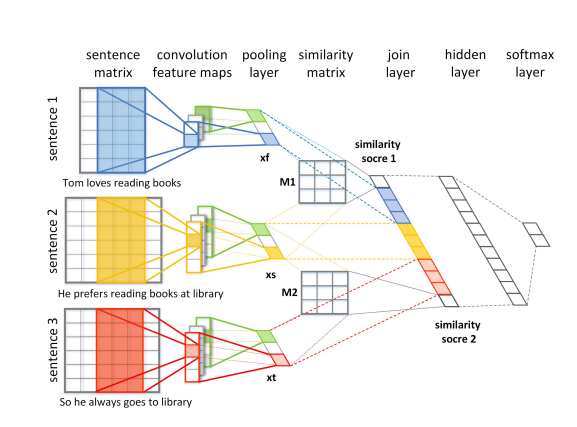


## **Model**

In [ ]:
class Model:
    
    def __init__(self):
      
        '''
          draw the ROC curve
            
          -- inputs: 
              None
          -- returns:
              None
        '''
        self.num_of_folds = int(5)
        self.dataset = None
        self.data = None
        self.model = None
        self.test_data = None
        
        self.preprocessor = Preprocessor()
        self.preprocessor.load_tokenizer(file_path = dataset_path + '/tokenizer.pkl')
        self.preprocessor.make_embeddings(path_to_embeddings=dataset_path + '/glove.6B.100d.txt')
    
    def make_dataset(self):

        '''
          Make tensorflow eager dataset object from the loaded data to model

          -- inputs: 
              None
          -- returns:
              None
        '''

        if self.data == None:
            print('cannot create dataset from empty data object, please load data first then create the dataset iterator')
        
        else:
            X_data, y_data = self.data[0], self.data[1]
            
            def generator():
                for train_index, test_index in KFold(n_splits=self.num_of_folds).split(X_data):
                    X_train, X_test = X_data[train_index], X_data[test_index]
                    y_train, y_test = y_data[train_index], y_data[test_index]
                    yield X_train,y_train,X_test,y_test

            self.dataset =  tf.data.Dataset.from_generator(generator, (tf.string,tf.int64,tf.string,tf.int64))
    
    

    def make_model(self):

        '''
          Make keras CNN model

          -- inputs: 
              None
          -- returns:
              None
        '''

        X_input =  tf.keras.Input(shape=(3, 100), name="input-sentences")
        
        
        embedding_layer = tf.keras.layers.Embedding(input_dim= len(self.preprocessor.tokenizer.word_index)+1, 
                                                    output_dim=self.preprocessor.embedding_dim, 
                                                    input_length=self.preprocessor.max_sequence_length,
                                                    trainable = False,
                                                    name='glove-embedding-layer')
        embedding_layer.build((None,))
        embedding_layer.set_weights([self.preprocessor.embeddings_matrix])
        
        first_sentence =  embedding_layer(X_input[:,0,:])
        second_sentence =  embedding_layer(X_input[:,1,:])
        third_sentence =  embedding_layer(X_input[:,2,:])
        
        convolutional_filters_map = tf.keras.layers.Conv1D(100,kernel_size=(3), activation='relu', use_bias=True, name='features-map')
        
        Xf = convolutional_filters_map(first_sentence)
        Xs = convolutional_filters_map(second_sentence)         
        Xt = convolutional_filters_map(third_sentence)   

        Xf = tf.keras.layers.MaxPool1D(98, name='first-sentence-pool')(Xf)
        Xs = tf.keras.layers.MaxPool1D(98, name='second-sentence-pool')(Xs)
        Xt = tf.keras.layers.MaxPool1D(98, name='third-sentence-pool')(Xt)

        similarity_fnc = SimilarityMatrix((100,100))

        sim_fs = similarity_fnc([Xf, Xs])
        sim_st = similarity_fnc([Xs, Xt])

        X = tf.keras.layers.concatenate([Xf, sim_fs, Xs, sim_st, Xt])

        ## TODO: this architecture requires grad search hyper-parameters tuning
        X = tf.keras.layers.Dense(256, activation='relu', name='fc1', use_bias=True)(X)
        X = tf.keras.layers.Dropout(0.333)(X)

        X = tf.keras.layers.Dense(512, activation='relu', name='fc2', use_bias=True)(X)
        X = tf.keras.layers.Dropout(0.333)(X)

        X = tf.keras.layers.Dense(512, activation='relu', name='fc3', use_bias=True)(X)
        X = tf.keras.layers.Dropout(0.333)(X)

        X = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(X)

        model = tf.keras.Model(inputs=[X_input], outputs=[X])

        self.model = model
    
    def load_data_from_csv(self, data_path, separator=',', split_train_test=False, make_balanced=False):
        
        '''
            load data from CSV file into dataframe
            
            -- inputs:
                data_path: path to file where data is saved
                separator (optional): value seprator to the file, default is comma
        '''
        
        self.data = pd.read_csv(f'{data_path}', sep=',')
        # separa um sequência de três orações de cada texto do dadtaset
        self.data['data'] = self.data['text'].apply(lambda x: x.strip().split('.')[:3])
        # para eliminar eventuais linhas com menos de 3 sentenças
        self.data = self.data.drop(self.data.loc[[(len(x) < 3) for x in self.data['data']]].index)
        self.data['data'] = self.data['data'].apply(lambda x: self.preprocessor.tokenize_data(x))

        if make_balanced:
          freq = list(df['label'].value_counts())
            #   freq = freq[0]//freq[1]-1
          min_freq = min(freq)

          df_coherent = self.data.loc[self.data['label'] == 1].sample(min_freq, replace=True)
          df_coherent_neg = self.data.loc[self.data['label'] == 0].sample(min_freq, replace=True)
          self.data = pd.concat([df_coherent, df_coherent_neg], ignore_index=True)
          
        #   df_coherent = self.data.loc[self.data['label'] == 1]
        #   df_coherent_replecated = pd.concat([df_coherent]*freq, ignore_index=True)
        #   self.data = pd.concat([df_coherent_replecated, self.data], ignore_index=True)
        
        if split_train_test:

          X_train, X_test, y_train, y_test = train_test_split(np.array(self.data['data'].values.tolist()), np.array(self.data['label'].values.tolist()).reshape(-1,1), test_size=0.2, random_state=42)
          self.data = (X_train, y_train)
          self.test_data = ( X_test, y_test)  
        else:
          self.data = (np.array(self.data['data'].values.tolist()), np.array(self.data['label'].values.tolist()).reshape(-1,1))

      

# **Train**

In [ ]:
m = Model()

Tokenizer ready from ./data/tokenizer.pkl. word count len: 11006
Making embedding with file: ./data/glove.6B.100d.txt


### **Training without Balancing**

In [ ]:
# read dataset sem balanceamento
m.load_data_from_csv(data_path=dataset_path+'/dataset.csv')

In [ ]:
# m.data[0][0]

In [ ]:
m.data[0].shape, m.data[1].shape, m.data[0][0].shape

((797, 3, 100), (797, 1), (3, 100))

In [ ]:
unique_elements, counts_elements = np.unique(m.data[1], return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[  0   1]
 [391 406]]


Tokenizer ready from ./data/tokenizer.pkl. word count len: 11006
Making embedding with file: ./data/glove.6B.100d.txt
Epoch 1/20
5/5 - 3s - loss: 0.8235 - acc: 0.5024 - val_loss: 0.7112 - val_acc: 0.4938 - 3s/epoch - 673ms/step
Epoch 2/20
5/5 - 1s - loss: 0.7013 - acc: 0.5369 - val_loss: 0.6861 - val_acc: 0.5562 - 573ms/epoch - 115ms/step
Epoch 3/20
5/5 - 1s - loss: 0.6803 - acc: 0.5463 - val_loss: 0.6840 - val_acc: 0.5813 - 594ms/epoch - 119ms/step
Epoch 4/20
5/5 - 1s - loss: 0.6807 - acc: 0.5840 - val_loss: 0.6786 - val_acc: 0.5625 - 593ms/epoch - 119ms/step
Epoch 5/20
5/5 - 1s - loss: 0.6580 - acc: 0.6264 - val_loss: 0.6662 - val_acc: 0.6062 - 591ms/epoch - 118ms/step
Epoch 6/20
5/5 - 1s - loss: 0.6225 - acc: 0.6797 - val_loss: 0.6567 - val_acc: 0.6000 - 575ms/epoch - 115ms/step
Epoch 7/20
5/5 - 1s - loss: 0.5926 - acc: 0.6813 - val_loss: 0.6605 - val_acc: 0.6187 - 594ms/epoch - 119ms/step
Epoch 8/20
5/5 - 1s - loss: 0.5376 - acc: 0.7425 - val_loss: 0.6738 - val_acc: 0.6125 - 603ms/

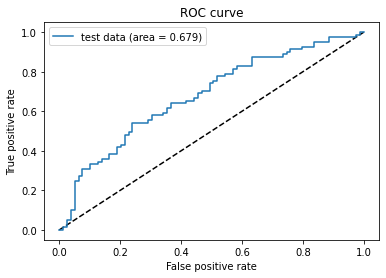

Tokenizer ready from ./data/tokenizer.pkl. word count len: 11006
Making embedding with file: ./data/glove.6B.100d.txt
Epoch 1/20
5/5 - 2s - loss: 0.7613 - acc: 0.5369 - val_loss: 0.7676 - val_acc: 0.4875 - 2s/epoch - 391ms/step
Epoch 2/20
5/5 - 1s - loss: 0.7605 - acc: 0.5243 - val_loss: 0.7007 - val_acc: 0.5250 - 588ms/epoch - 118ms/step
Epoch 3/20
5/5 - 1s - loss: 0.7008 - acc: 0.5196 - val_loss: 0.6718 - val_acc: 0.5500 - 580ms/epoch - 116ms/step
Epoch 4/20
5/5 - 1s - loss: 0.6854 - acc: 0.5636 - val_loss: 0.6656 - val_acc: 0.6375 - 586ms/epoch - 117ms/step
Epoch 5/20
5/5 - 1s - loss: 0.6690 - acc: 0.5918 - val_loss: 0.6497 - val_acc: 0.6375 - 596ms/epoch - 119ms/step
Epoch 6/20
5/5 - 1s - loss: 0.6454 - acc: 0.6499 - val_loss: 0.6343 - val_acc: 0.6313 - 597ms/epoch - 119ms/step
Epoch 7/20
5/5 - 1s - loss: 0.6182 - acc: 0.6484 - val_loss: 0.6149 - val_acc: 0.6750 - 588ms/epoch - 118ms/step
Epoch 8/20
5/5 - 1s - loss: 0.5999 - acc: 0.6797 - val_loss: 0.6128 - val_acc: 0.6000 - 607ms/

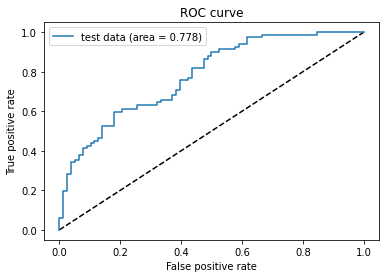

Tokenizer ready from ./data/tokenizer.pkl. word count len: 11006
Making embedding with file: ./data/glove.6B.100d.txt
Epoch 1/20
5/5 - 2s - loss: 0.7421 - acc: 0.4969 - val_loss: 0.7339 - val_acc: 0.5157 - 2s/epoch - 408ms/step
Epoch 2/20
5/5 - 1s - loss: 0.6922 - acc: 0.5674 - val_loss: 0.6868 - val_acc: 0.5409 - 587ms/epoch - 117ms/step
Epoch 3/20
5/5 - 1s - loss: 0.6715 - acc: 0.5815 - val_loss: 0.6713 - val_acc: 0.5849 - 577ms/epoch - 115ms/step
Epoch 4/20
5/5 - 1s - loss: 0.6493 - acc: 0.6223 - val_loss: 0.6910 - val_acc: 0.6038 - 596ms/epoch - 119ms/step
Epoch 5/20
5/5 - 1s - loss: 0.5946 - acc: 0.6975 - val_loss: 0.7368 - val_acc: 0.5535 - 589ms/epoch - 118ms/step
2/2 [==============================] - 0s 14ms/step - loss: 0.7368 - acc: 0.5535
fold #3 test loss: 0.7368264198303223, test acc: 0.553459107875824
Average precision-recall score: 0.57


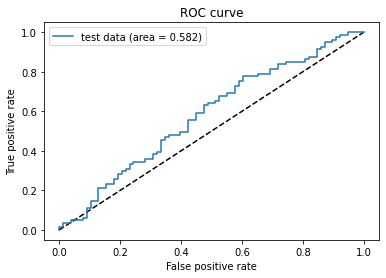

Tokenizer ready from ./data/tokenizer.pkl. word count len: 11006
Making embedding with file: ./data/glove.6B.100d.txt
Epoch 1/20
5/5 - 2s - loss: 0.8367 - acc: 0.4718 - val_loss: 0.7290 - val_acc: 0.4906 - 2s/epoch - 408ms/step
Epoch 2/20
5/5 - 1s - loss: 0.7184 - acc: 0.4843 - val_loss: 0.7029 - val_acc: 0.5157 - 585ms/epoch - 117ms/step
Epoch 3/20
5/5 - 1s - loss: 0.6958 - acc: 0.5345 - val_loss: 0.6844 - val_acc: 0.5283 - 582ms/epoch - 116ms/step
Epoch 4/20
5/5 - 1s - loss: 0.6895 - acc: 0.5564 - val_loss: 0.6823 - val_acc: 0.5346 - 584ms/epoch - 117ms/step
Epoch 5/20
5/5 - 1s - loss: 0.6753 - acc: 0.5909 - val_loss: 0.6777 - val_acc: 0.5472 - 584ms/epoch - 117ms/step
Epoch 6/20
5/5 - 1s - loss: 0.6696 - acc: 0.5940 - val_loss: 0.6640 - val_acc: 0.6478 - 589ms/epoch - 118ms/step
Epoch 7/20
5/5 - 1s - loss: 0.6454 - acc: 0.6458 - val_loss: 0.6514 - val_acc: 0.5912 - 593ms/epoch - 119ms/step
Epoch 8/20
5/5 - 1s - loss: 0.6234 - acc: 0.6520 - val_loss: 0.6139 - val_acc: 0.6730 - 592ms/

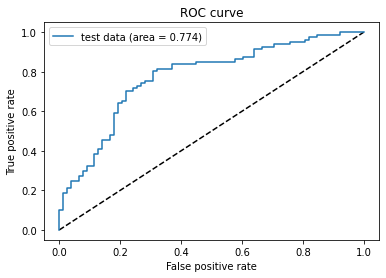

Tokenizer ready from ./data/tokenizer.pkl. word count len: 11006
Making embedding with file: ./data/glove.6B.100d.txt
Epoch 1/20
5/5 - 2s - loss: 0.7524 - acc: 0.4859 - val_loss: 0.6955 - val_acc: 0.4969 - 2s/epoch - 391ms/step
Epoch 2/20
5/5 - 1s - loss: 0.7018 - acc: 0.5266 - val_loss: 0.7078 - val_acc: 0.5157 - 583ms/epoch - 117ms/step
Epoch 3/20
5/5 - 1s - loss: 0.6870 - acc: 0.5439 - val_loss: 0.6872 - val_acc: 0.5346 - 568ms/epoch - 114ms/step
Epoch 4/20
5/5 - 1s - loss: 0.6534 - acc: 0.6129 - val_loss: 0.6883 - val_acc: 0.5660 - 575ms/epoch - 115ms/step
Epoch 5/20
5/5 - 1s - loss: 0.6289 - acc: 0.6536 - val_loss: 0.6971 - val_acc: 0.5849 - 598ms/epoch - 120ms/step
2/2 [==============================] - 0s 20ms/step - loss: 0.6971 - acc: 0.5849
fold #5 test loss: 0.6971328854560852, test acc: 0.5849056839942932
Average precision-recall score: 0.57


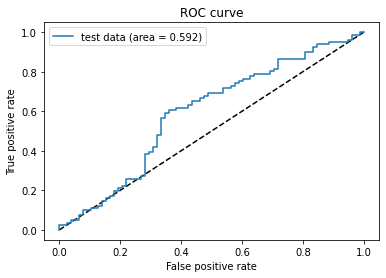

In [ ]:
ModelHelper.train_model_kfolds(m.data, 
                               Model, 
                               ModelHelper.negative_log_likelihood, 
                               m.num_of_folds, 
                               plot_roc=True)

### **Trainig with Balanced Dataset**

In [ ]:
# m.load_data_from_csv(data_path=dataset_path+'/dataset.csv')
m.load_data_from_csv(data_path=dataset_path+'/dataset.csv', make_balanced=True)
unique_elements, counts_elements = np.unique(m.data[1], return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[  0   1]
 [394 394]]


Tokenizer ready from ./data/tokenizer.pkl. word count len: 11006
Making embedding with file: ./data/glove.6B.100d.txt
Epoch 1/20
5/5 - 2s - loss: 0.8249 - acc: 0.5016 - val_loss: 0.7004 - val_acc: 0.4937 - 2s/epoch - 404ms/step
Epoch 2/20
5/5 - 1s - loss: 0.7070 - acc: 0.5270 - val_loss: 0.6897 - val_acc: 0.5190 - 593ms/epoch - 119ms/step
Epoch 3/20
5/5 - 1s - loss: 0.6895 - acc: 0.5603 - val_loss: 0.6815 - val_acc: 0.5570 - 568ms/epoch - 114ms/step
Epoch 4/20
5/5 - 1s - loss: 0.6718 - acc: 0.5778 - val_loss: 0.6789 - val_acc: 0.5380 - 579ms/epoch - 116ms/step
Epoch 5/20
5/5 - 1s - loss: 0.6711 - acc: 0.5714 - val_loss: 0.6546 - val_acc: 0.6646 - 572ms/epoch - 114ms/step
Epoch 6/20
5/5 - 1s - loss: 0.6122 - acc: 0.6873 - val_loss: 0.6366 - val_acc: 0.5949 - 566ms/epoch - 113ms/step
Epoch 7/20
5/5 - 1s - loss: 0.5682 - acc: 0.7206 - val_loss: 0.5858 - val_acc: 0.6899 - 566ms/epoch - 113ms/step
Epoch 8/20
5/5 - 1s - loss: 0.4498 - acc: 0.8095 - val_loss: 0.5334 - val_acc: 0.7278 - 576ms/

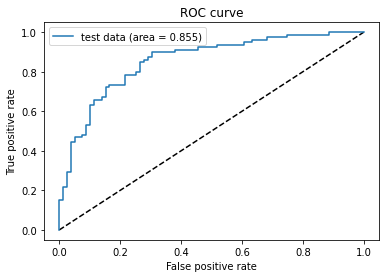

Tokenizer ready from ./data/tokenizer.pkl. word count len: 11006
Making embedding with file: ./data/glove.6B.100d.txt
Epoch 1/20
5/5 - 2s - loss: 0.8053 - acc: 0.5032 - val_loss: 0.6951 - val_acc: 0.4367 - 2s/epoch - 418ms/step
Epoch 2/20
5/5 - 1s - loss: 0.7236 - acc: 0.5143 - val_loss: 0.6963 - val_acc: 0.5190 - 576ms/epoch - 115ms/step
Epoch 3/20
5/5 - 1s - loss: 0.7034 - acc: 0.5190 - val_loss: 0.6886 - val_acc: 0.5380 - 569ms/epoch - 114ms/step
Epoch 4/20
5/5 - 1s - loss: 0.6816 - acc: 0.5413 - val_loss: 0.6842 - val_acc: 0.5127 - 576ms/epoch - 115ms/step
Epoch 5/20
5/5 - 1s - loss: 0.6611 - acc: 0.6159 - val_loss: 0.6723 - val_acc: 0.5759 - 572ms/epoch - 114ms/step
Epoch 6/20
5/5 - 1s - loss: 0.6340 - acc: 0.7000 - val_loss: 0.6388 - val_acc: 0.6709 - 562ms/epoch - 112ms/step
Epoch 7/20
5/5 - 1s - loss: 0.5695 - acc: 0.7476 - val_loss: 0.5849 - val_acc: 0.6899 - 577ms/epoch - 115ms/step
Epoch 8/20
5/5 - 1s - loss: 0.4994 - acc: 0.7841 - val_loss: 0.5395 - val_acc: 0.7278 - 588ms/

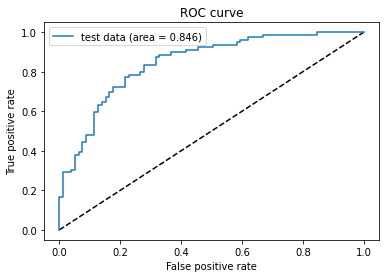

Tokenizer ready from ./data/tokenizer.pkl. word count len: 11006
Making embedding with file: ./data/glove.6B.100d.txt
Epoch 1/20
5/5 - 2s - loss: 0.7905 - acc: 0.5079 - val_loss: 0.6904 - val_acc: 0.5000 - 2s/epoch - 414ms/step
Epoch 2/20
5/5 - 1s - loss: 0.6875 - acc: 0.5651 - val_loss: 0.6849 - val_acc: 0.5316 - 573ms/epoch - 115ms/step
Epoch 3/20
5/5 - 1s - loss: 0.6970 - acc: 0.5079 - val_loss: 0.6740 - val_acc: 0.5949 - 566ms/epoch - 113ms/step
Epoch 4/20
5/5 - 1s - loss: 0.6676 - acc: 0.5921 - val_loss: 0.6566 - val_acc: 0.6835 - 596ms/epoch - 119ms/step
Epoch 5/20
5/5 - 1s - loss: 0.6479 - acc: 0.6333 - val_loss: 0.6227 - val_acc: 0.7025 - 592ms/epoch - 118ms/step
Epoch 6/20
5/5 - 1s - loss: 0.5795 - acc: 0.7000 - val_loss: 0.5863 - val_acc: 0.6835 - 589ms/epoch - 118ms/step
Epoch 7/20
5/5 - 1s - loss: 0.5035 - acc: 0.7667 - val_loss: 0.5622 - val_acc: 0.7025 - 597ms/epoch - 119ms/step
Epoch 8/20
5/5 - 1s - loss: 0.4266 - acc: 0.8016 - val_loss: 0.5369 - val_acc: 0.7089 - 573ms/

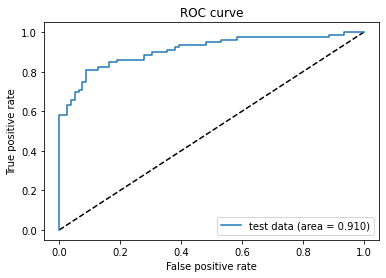

Tokenizer ready from ./data/tokenizer.pkl. word count len: 11006
Making embedding with file: ./data/glove.6B.100d.txt
Epoch 1/20
5/5 - 2s - loss: 0.7556 - acc: 0.4976 - val_loss: 0.6878 - val_acc: 0.5796 - 2s/epoch - 410ms/step
Epoch 2/20
5/5 - 1s - loss: 0.7005 - acc: 0.5246 - val_loss: 0.6850 - val_acc: 0.5541 - 573ms/epoch - 115ms/step
Epoch 3/20
5/5 - 1s - loss: 0.6785 - acc: 0.5578 - val_loss: 0.6979 - val_acc: 0.5541 - 581ms/epoch - 116ms/step
Epoch 4/20
5/5 - 1s - loss: 0.6694 - acc: 0.5959 - val_loss: 0.6756 - val_acc: 0.5223 - 585ms/epoch - 117ms/step
Epoch 5/20
5/5 - 1s - loss: 0.6411 - acc: 0.6371 - val_loss: 0.6485 - val_acc: 0.6178 - 568ms/epoch - 114ms/step
Epoch 6/20
5/5 - 1s - loss: 0.5892 - acc: 0.7021 - val_loss: 0.6086 - val_acc: 0.6879 - 572ms/epoch - 114ms/step
Epoch 7/20
5/5 - 1s - loss: 0.4835 - acc: 0.7845 - val_loss: 0.5636 - val_acc: 0.7070 - 584ms/epoch - 117ms/step
Epoch 8/20
5/5 - 1s - loss: 0.3605 - acc: 0.8494 - val_loss: 0.5274 - val_acc: 0.7771 - 586ms/

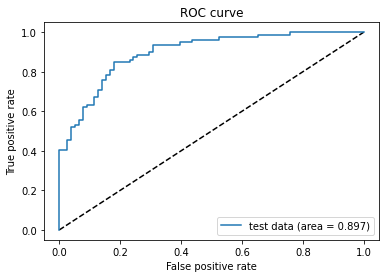

Tokenizer ready from ./data/tokenizer.pkl. word count len: 11006
Making embedding with file: ./data/glove.6B.100d.txt
Epoch 1/20
5/5 - 2s - loss: 0.8467 - acc: 0.4786 - val_loss: 0.7096 - val_acc: 0.4968 - 2s/epoch - 485ms/step
Epoch 2/20
5/5 - 1s - loss: 0.7240 - acc: 0.4945 - val_loss: 0.6872 - val_acc: 0.5669 - 584ms/epoch - 117ms/step
Epoch 3/20
5/5 - 1s - loss: 0.6795 - acc: 0.5531 - val_loss: 0.6721 - val_acc: 0.6115 - 571ms/epoch - 114ms/step
Epoch 4/20
5/5 - 1s - loss: 0.6818 - acc: 0.5943 - val_loss: 0.6665 - val_acc: 0.6624 - 571ms/epoch - 114ms/step
Epoch 5/20
5/5 - 1s - loss: 0.6601 - acc: 0.6181 - val_loss: 0.6476 - val_acc: 0.6943 - 574ms/epoch - 115ms/step
Epoch 6/20
5/5 - 1s - loss: 0.6266 - acc: 0.6878 - val_loss: 0.6085 - val_acc: 0.6943 - 570ms/epoch - 114ms/step
Epoch 7/20
5/5 - 1s - loss: 0.5709 - acc: 0.7480 - val_loss: 0.5507 - val_acc: 0.7261 - 583ms/epoch - 117ms/step
Epoch 8/20
5/5 - 1s - loss: 0.4740 - acc: 0.7702 - val_loss: 0.4937 - val_acc: 0.7261 - 573ms/

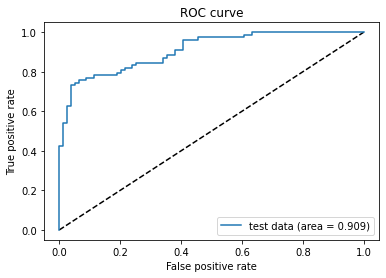

In [ ]:
ModelHelper.train_model_kfolds(m.data, Model, ModelHelper.negative_log_likelihood, m.num_of_folds, plot_roc=True)

### **Training on Full Dataset**

In [ ]:
ModelHelper.train_model(data=m.data, 
                        model=m, 
                        loss_func = ModelHelper.negative_log_likelihood, 
                        epoches=100,
                        verbose=1,
                        batch_size=128,
                        early_stop=True)

AttributeError: ignored

### **Conclusions**

Comparando os resultados da abordagem com e sem balancemaento das classes, podemos notar uma melhora substancial com os dados balanceados, partindo de uma média de cerca de 60% para perto de 90% de Precison-Recall score.    


TODO: Aplicar a massa de teste e verificar a performance.

# Debug

In [ ]:
my_preprocessor = Preprocessor()
my_preprocessor.load_tokenizer(file_path = dataset_path + '/tokenizer.pkl')
my_preprocessor.make_embeddings(path_to_embeddings=dataset_path + '/glove.6B.100d.txt')

Tokenizer ready from ./data/tokenizer.pkl. word count len: 11006
Making embedding with file: ./data/glove.6B.100d.txt


In [ ]:
data = pd.read_csv(f'{dataset_path}/dataset.csv', sep=',')
data['data'] = data['text'].apply(lambda x: x.strip().split('.')[:3])
# para eliminar eventuais linhas com menos de 3 sentenças
data = data.drop(data.loc[[(len(x) < 3) for x in data['data']]].index)
data['data'] = data['data'].apply(lambda x: my_preprocessor.tokenize_data(x))
# limpara sequencias com menos de 3 oracoes


data['data'][0]
# data['data'].shape


In [ ]:
freq = list(df['label'].value_counts())
# freq = freq[0]//freq[1]-1
min_freq = min(freq)
# min_idx = np.argmax(freq)

df_coherent = data.loc[data['label'] == 1].sample(min_freq, replace=True)
df_coherent_neg = data.loc[data['label'] == 0].sample(min_freq, replace=True)
# df_coherent_replecated = pd.concat([df_coherent]*freq, ignore_index=True)
data = pd.concat([df_coherent, df_coherent_neg], ignore_index=True)
# 1    406
# 0    394
# Name: labe

In [ ]:
m_data = (np.array(data['data'].values.tolist()), np.array(data['label'].values.tolist()).reshape(-1,1))

In [ ]:
m_data[0][0]

array([[ 285, 1239,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [  29,   53,    7, 5901,  802,  658,  383,    7,   72,   21,   19,
          18,  830,  244,  269, 1419,   30, 1420,   50,    5, 3372,    1,
          86,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    

In [ ]:
for i, j in enumerate(m_data[0]):
    if len(m_data[0][i]) <3:
        print(m_data[0][i])
        break

In [ ]:
# get x and y date (array tokenizer index, labels (0 , 1))
X_data, y_data = m_data[0].astype(np.float32), m_data[1].astype(np.float32)

In [ ]:
# TREINANDO O MODELO MANUALMENTE

# Tres sentenças de 100 tokens de embeding
X_input =  tf.keras.Input(shape=(3, 100), name="input-sentences")

embedding_layer = tf.keras.layers.Embedding(input_dim= len(my_preprocessor.tokenizer.word_index)+1, 
                                            output_dim=my_preprocessor.embedding_dim, 
                                            input_length=my_preprocessor.max_sequence_length,
                                            trainable = False,
                                            name='glove-embedding-layer')
embedding_layer.build((None,))
embedding_layer.set_weights([my_preprocessor.embeddings_matrix])

first_sentence =  embedding_layer(X_input[:,0,:])
second_sentence =  embedding_layer(X_input[:,1,:])
third_sentence =  embedding_layer(X_input[:,2,:])

convolutional_filters_map = tf.keras.layers.Conv1D(100,kernel_size=(3), activation='relu', use_bias=True, name='features-map')

Xf = convolutional_filters_map(first_sentence)
Xs = convolutional_filters_map(second_sentence)         
Xt = convolutional_filters_map(third_sentence)   

Xf = tf.keras.layers.MaxPool1D(98, name='first-sentence-pool')(Xf)
Xs = tf.keras.layers.MaxPool1D(98, name='second-sentence-pool')(Xs)
Xt = tf.keras.layers.MaxPool1D(98, name='third-sentence-pool')(Xt)

similarity_fnc = SimilarityMatrix((100,100))

sim_fs = similarity_fnc([Xf, Xs])
sim_st = similarity_fnc([Xs, Xt])

X = tf.keras.layers.concatenate([Xf, sim_fs, Xs, sim_st, Xt])

## TODO: this architecture requires grad search hyper-parameters tuning
X = tf.keras.layers.Dense(256, activation='relu', name='fc1', use_bias=True)(X)
X = tf.keras.layers.Dropout(0.333)(X)

X = tf.keras.layers.Dense(512, activation='relu', name='fc2', use_bias=True)(X)
X = tf.keras.layers.Dropout(0.333)(X)

X = tf.keras.layers.Dense(512, activation='relu', name='fc3', use_bias=True)(X)
X = tf.keras.layers.Dropout(0.333)(X)

X = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(X)

model = tf.keras.Model(inputs=[X_input], outputs=[X])



In [ ]:
ModelHelper.train_model_kfolds(m.data, Model, ModelHelper.negative_log_likelihood, m.num_of_folds, plot_roc=True)

In [ ]:
preprocessor = Preprocessor()
preprocessor.load_tokenizer(file_path=dataset_path+'/tokenizer.pkl')
# processor.make_tokenizer( )
# preprocessor.makeoad_tokenizer(file_path=dataset_path+'/tokenizer.pkl')

Tokenizer ready from ./data/tokenizer.pkl. word count len: 11006


In [ ]:
preprocessor.make_embeddings(path_to_embeddings=dataset_path+'/glove.6B.100d.txt')

Making embedding with file: ./data/glove.6B.100d.txt


In [ ]:
ls -l ./data


total 3045232
-rw-r--r-- 1 root root     721722 Nov 20 14:11 dataset.csv
-rw-r--r-- 1 root root     839130 Nov 20 14:05 Enron_dev.jsonl
-rw-r--r-- 1 root root     846524 Nov 20 14:06 Enron_test.jsonl
-rw-r--r-- 1 root root    3313971 Nov 20 14:06 Enron_train.jsonl
-rw-rw-r-- 1 root root  347116733 Aug  4  2014 glove.6B.100d.txt
-rw-rw-r-- 1 root root  693432828 Aug  4  2014 glove.6B.200d.txt
-rw-rw-r-- 1 root root 1037962819 Aug 27  2014 glove.6B.300d.txt
-rw-rw-r-- 1 root root  171350079 Aug  4  2014 glove.6B.50d.txt
-rw-r--r-- 1 root root  862182613 Oct 25  2015 glove.6B.zip
-rw-r--r-- 1 root root     514074 Nov 20 14:34 tokenizer.pkl
